In [1]:
from system import *
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy.integrate import solve_ivp

np.random.seed(232)
x0=np.random.random(2) * 2
x0_2=np.random.random(2)

In [2]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

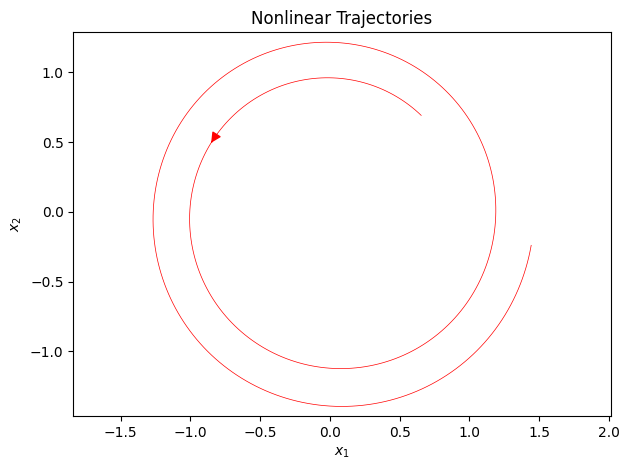

In [3]:
import numpy as np

alpha = 1
c = 0.5

fig, ax = plt.subplots()
steps = 400
x = np.zeros((steps,2))
X0 = [x0]
W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
f = lambda x: 1 / tau * (-x + phi(W@x + theta))
dt = 0.05


for x0 in X0:
    x[0] = np.array(x0)
    for i in range(1, steps):
        x[i] = f(x[i - 1]) * dt + x[i - 1]
    l, = ax.plot(x[:, 0], x[:, 1], color = 'red', lw=0.5)
    # add_arrow(l, position=x[20][0])
    add_arrow(l, position=x[60][0])

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Nonlinear Trajectories')

fig.tight_layout()
# plt.show()
plt.savefig('s2q5.jpeg', dpi=700)

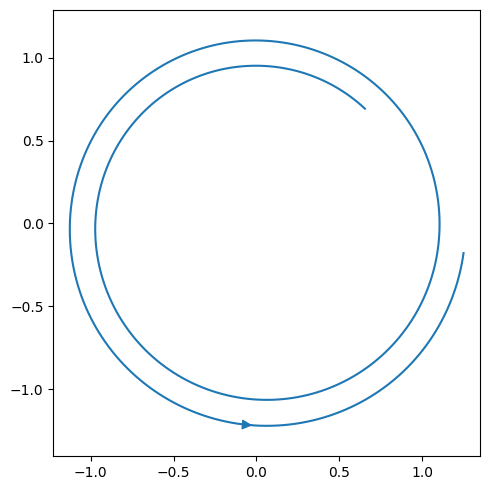

In [53]:
%matplotlib inline
fig, ax = plt.subplots()

W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
f = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

t_eval = np.arange(0, 20, 0.05)
sol = solve_ivp(f, t_span=[0, 20], y0=x0, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='x(t)')
ax.set_aspect('equal', adjustable='datalim')
add_arrow(l)

fig.set_size_inches((5, 5))
plt.tight_layout()
plt.savefig('p1.jpeg', dpi=500)

# Picard Iterations

285.85684337892394
1097.503671133197
3697.9966320577923
10258.480462430747
26245.044564289226
56517.26107564108
102552.83139581674
161945.33266071466
226407.55567340317
280582.8222527066
307546.69223345997
298760.71632814506
258781.80169691975
200964.6999312057
140145.51592224574
87531.49502678931
48741.38521160736
24012.669929033105
10184.599388070681
3547.405172786364
1029.3439043345272
268.2926175814566
109.3289043300066
76.64269790611259
45.911954642484275
23.15819194041919
11.507955319610975
5.14571352412631
2.2118917874771045
0.8363955231796313
0.3215755379384461
0.11100534949290977
0.03917870778876348
0.012510161671507732
0.00411180664911416
0.0012298412694661126
0.0003794929655452094
0.00010703308859717172
3.1170827602994756e-05
8.328966077808441e-06
2.2979631468722963e-06
5.837638925856568e-07
1.5303527689125976e-07
3.706547591043877e-08
9.255180300336557e-09
2.1424278747679764e-09
5.106836296822937e-10


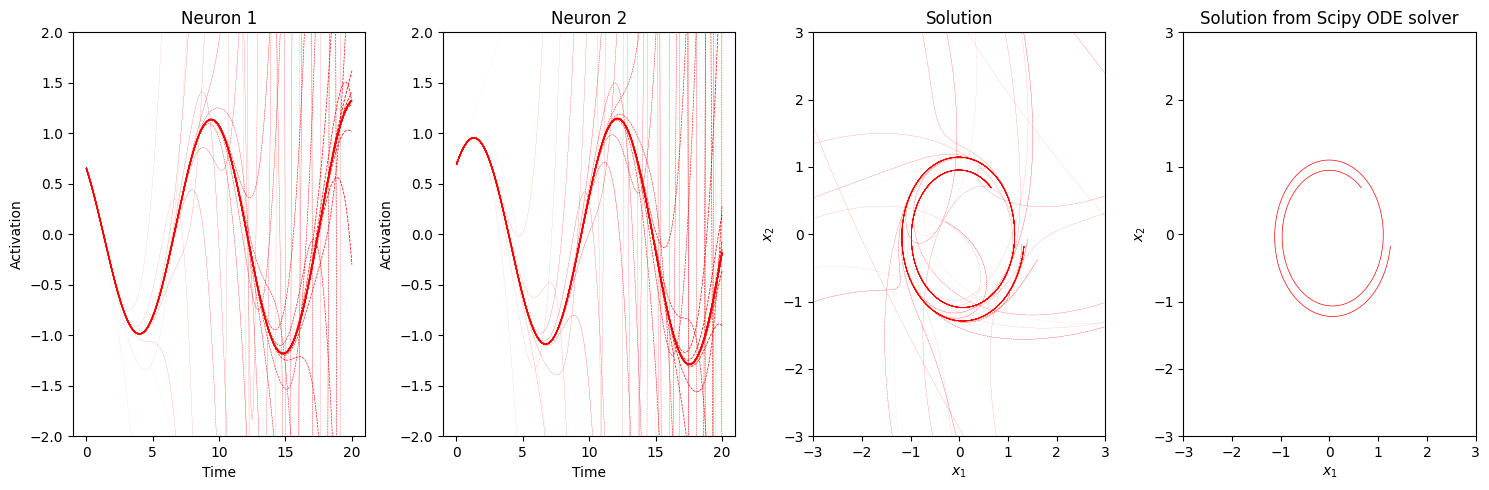

In [65]:
def integrate(func, x, a, b, axis=0, dt=0.001):
    if a == b:
        return np.zeros(x.shape[1])
    t = np.linspace(a, b, num=int((b - a) / dt))
    fs = func(x, t)
    # print(dt)
    return np.trapz(fs, dx=dt, axis=0)


def picard_iter(x, f, T, x0, t0=0, dt=0.01):
    x1 = x0 + np.array([integrate(lambda x, s: f(x, s, tf), x[:i], T[0], tf, dt=dt) for i, tf in enumerate(T)]) #integrate(lambda t: f(x0, t), t0, T)
    return x1

def picard_solve(f, T, x0, verbose=False, thresh=10**(-9), dt=0.01):
    # print(dt)
    xlast = x0
    xcurr = -np.inf
    xsols = []
    i = 0
    picard_dists = []
    while True:
        xcurr = picard_iter(xlast, f, T, x0, dt=dt)
        xsols.append(xcurr.copy())
        picard_dists.append(np.linalg.norm(xlast - xcurr) )
        if verbose: print(picard_dists[-1])
        if picard_dists[-1] < thresh:
            break
        xlast = xcurr.copy()
        i += 1
        
    return xsols

phi = lambda x: np.tanh(x)
alpha = 10
f = lambda x, s, t: 1 / tau * (-x + alpha * phi(np.array([W@v + theta for v in x]))) 

DT = 0.01
t0, tfinal = 0, 20
T = np.linspace(t0, tfinal, num=int((tfinal - t0) / DT))
NEURONS = W.shape[0]
x_init = np.zeros((T.shape[0], NEURONS)) + np.array([x0])

xsols = picard_solve(f, T, x_init, dt=DT, verbose=True)
    
PER_ROW = NEURONS
fig, axs = plt.subplots(nrows=1, ncols=4)
axs = axs.flatten()
for n in range(NEURONS):
    for i, x in enumerate(xsols):
        style = None
        lw = (i+1)/(len(xsols) + 1)
        if lw < 1:
            style = 'dashed'
        axs[n].plot(T, x[:,n], color='red', lw=lw, linestyle=style)
        axs[n].set_xlabel('Time')
        axs[n].set_ylabel('Activation')
        axs[n].set_title(f'Neuron {n+1}')
        axs[n].set_ylim((-2, 2))
    
for i, x in enumerate(xsols):
    style = None
    lw = (i+1) / (2 * len(xsols) + 1)
    if i + 1 != len(xsols):
        style = 'dashed'
    axs[2].plot(x[:,0], x[:,1], color='red', lw=lw, linestyle=style)
    axs[2].set_xlabel('$x_1$')
    axs[2].set_ylabel('$x_2$')
    axs[2].set_title(f'Solution')
    axs[2].set_ylim((-3, 3))
    axs[2].set_xlim((-3, 3))
    
axs[3].plot(sol.y[0], sol.y[1], color='red', lw=lw, linestyle=style)
axs[3].set_xlabel('$x_1$')
axs[3].set_ylabel('$x_2$')
axs[3].set_title(f'Solution from Scipy ODE solver')
axs[3].set_ylim((-3, 3))
axs[3].set_xlim((-3, 3))

fig.set_size_inches((15, 5))
fig.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/picard.png', dpi=500)

# if NEURONS == 2 and plot2D:
#     fig, ax = plt.subplots()
#     l, = ax.plot(xsols[-1][:, 0], xsols[-1][:, 1])
#     add_arrow(l)
#     fig.set_size_inches((5, 5))
#     fig.tight_layout()
#     plt.show()

# Lipschitz

In [110]:
print(2 * np.linalg.norm(W) + 1)
xs = np.random.random((2, 100))
m = np.max(np.linalg.norm((W@xs).T, axis=0))
a  = np.argmax(np.linalg.norm(W@xs, axis=0))
print(np.linalg.eig(W))
print(m * 2 + 1)

1.3316818475723267
(array([0.10172155+0.05834026j, 0.10172155-0.05834026j], dtype=complex64), array([[ 0.00584245-0.704815j,  0.00584245+0.704815j],
       [-0.70936716+0.j      , -0.70936716-0.j      ]], dtype=complex64))
2.737754672547551


[233.04050284 170.84686465]
1.4142127487126304
1.4139571227699579
[  31 -100]


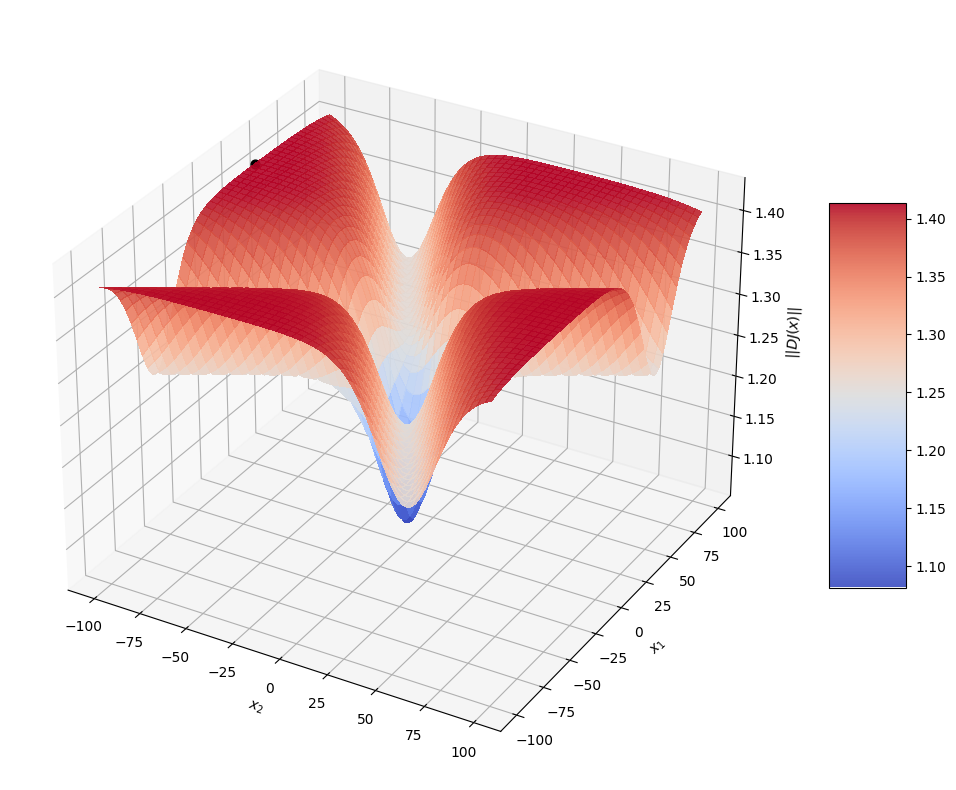

In [138]:
from system import weight_matrix, bias_matrix
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from autograd import jacobian
import matplotlib.pyplot as plt
from matplotlib import cm



np.random.seed(232) #3 #232: BFGS #134: COBYLA
tau = 1.0
NEURONS = 2
# W = np.eye(NEURONS)
# x0 = np.ones(NEURONS) * np.random.random()
x_init = np.ones(NEURONS) * 10
W = weight_matrix
theta = bias_matrix
# phi = lambda x: np.tanh(x)
phi = lambda x: 1 / (1 + np.exp(-x))
alpha = 10
f = lambda x: (-x + alpha * phi(W@x + theta))

jacobian_cost = jacobian(f)
def func(x):
    global jacobian_cost
    return -np.linalg.norm(jacobian_cost(x))

res = scipy.optimize.minimize(
    fun=func,
    x0=x_init,
    method='SLSQP'
)
x_min = res.x
print(x_min)
print(-func(x_min))
L = -func(x_min)
L = 1.43
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
dt = 1
BOUND = 100
X = np.arange(-BOUND, BOUND, dt)
Y = np.arange(-BOUND, BOUND, dt)
R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
# print(Z)
Z = np.zeros((X.shape[0], Y.shape[0]))
maxz = -np.inf,
max_xy = np.zeros(2)
for i, x in enumerate(X):
    print(f'{i / len(X) * 100:.2f}%', end='\r')
    for j, y in enumerate(Y):
        v = np.array([x,y])
        Z[i,j] = -func(v)
        if Z[i,j] > maxz:
            maxz = Z[i,j]
            max_xy = np.array([x, y])
        # if np.linalg.norm(x_min - v) < 0.5:
        #     print(f'({x}, {y})', Z[i,j])
X, Y = np.meshgrid(X, Y)
print(maxz)
print(max_xy)
# ax.scatter(*x_min[::-1], -func(x_min), color='black', s=40, zorder=1)
ax.scatter(*max_xy[::-1], maxz, color='black', s=40, zorder=1)

# Plot the surface.
cmap = cm.coolwarm
cmap = cmap(np.arange(cmap.N))
cmap[:,-1] = 0.9
from matplotlib.colors import ListedColormap

cmap = ListedColormap(cmap)

surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                    linewidth=0, antialiased=False)


ax.set_xlabel('$x_2$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$||DJ(x)||$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.set_size_inches((10,8))
fig.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/lipviz.png')

In [11]:
np.ones((10,2)) + np.random.random((1,2))

array([[1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161]])

In [23]:
np.random.random((2))

array([0.42610582, 0.21145819])

# PERTURBATIONS

parameter

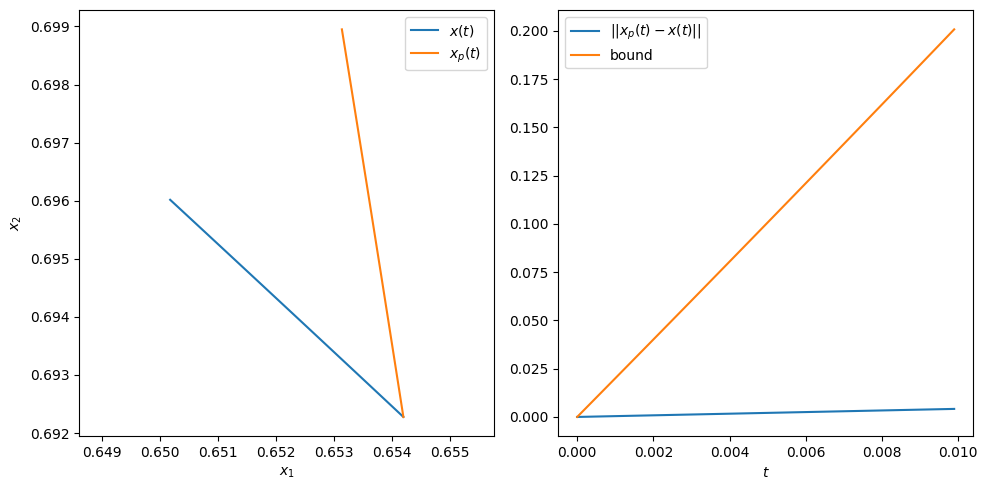

In [133]:
%matplotlib inline
fig, (ax, bx) = plt.subplots(ncols=2)

W = weight_matrix
theta = bias_matrix
pert = 0.03
alpha = 10
phi = lambda x: np.tanh(x)
f = lambda t, x: 1 / tau * (-x + alpha * phi(W@x + theta))
f_pert = lambda t, x: 1 / tau * (-x + alpha * phi(W@x + theta + pert))

tfinal = 0.01
t_eval = np.arange(0, tfinal, 0.0001)
sol = solve_ivp(f, t_span=[0, tfinal], y0=x0, t_eval=t_eval)
sol_pert = solve_ivp(f_pert, t_span=[0, tfinal], y0=x0, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='$x(t)$')
l, = ax.plot(sol_pert.y[0], sol_pert.y[1], label='$x_p(t)$')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
# add_arrow(l)

bx.plot(t_eval, np.linalg.norm(sol.y - sol_pert.y, axis=0), label='$||x_p(t) - x(t)||$')
bx.plot(t_eval, 20 * (t_eval) * np.exp(L*t_eval), label='bound')
bx.legend()
bx.set_xlabel('$t$')
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/pert_param.png', dpi=500)

initial conditions

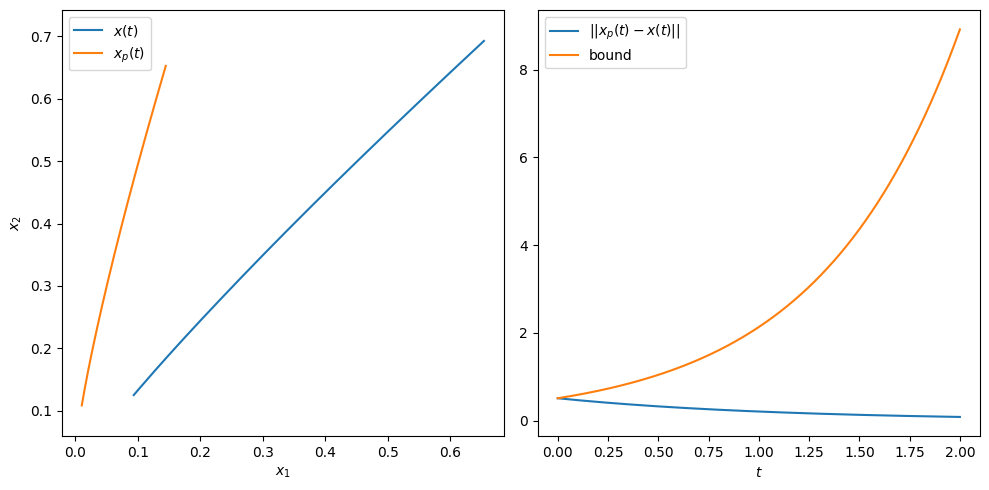

In [135]:
%matplotlib inline
fig, (ax, bx) = plt.subplots(ncols=2)


W = weight_matrix
theta = bias_matrix
phi = lambda x: np.tanh(x)
f = lambda t, x: 1 / tau * (-x + phi(W@x + theta))
f_pert = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

tfinal = 2
t_eval = np.arange(0, tfinal, 0.0001)
sol = solve_ivp(f, t_span=[0, tfinal], y0=x0, t_eval=t_eval)
sol_pert = solve_ivp(f, t_span=[0, tfinal], y0=x0_2, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='$x(t)$')
l, = ax.plot(sol_pert.y[0], sol_pert.y[1], label='$x_p(t)$')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
# add_arrow(l)

bx.plot(t_eval, np.linalg.norm(sol.y - sol_pert.y, axis=0), label='$||x_p(t) - x(t)||$')
bx.plot(t_eval, np.linalg.norm(x0 - x0_2) * np.exp(L*t_eval), label='bound')
bx.set_xlabel('$t$')
bx.legend()

fig.set_size_inches((10, 5))
fig.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/pert_init.png', dpi=500)

In [104]:
np.random.random()

0.3461387204690489

In [128]:
x0, x0_2

(array([0.65419265, 0.69227744]), array([0.14480575, 0.65234019]))